# **US High Yield Portfolio**

The objective of this investment portfolio is to build a diversified, low risk and high yield investsments, with an aim to offer a monthly dividend payout.

In [269]:
#!pip install yahoo_fin --upgrade
#!pip install PyPortfolioOpt

In [270]:
import ftplib 
import feedparser
import io
import json
import datetime
import pandas as pd
import requests, requests_html
from yahoo_fin.stock_info import get_data, get_quote_table, get_quote_data

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import cla
from pypfopt import plotting

In [271]:
# define stock list
ticker_list = ['GDV', 'LTC', 'EPD', 'DLY', 'AGNC', 'HRZN', 'PFLT', 'ARKK', 'ARKG',  
               'CPER', 'PIN', 'KRBN', 'PSLV', 'MP', 'GLD', 'EWU', 'SII',
               '^GSPC', 'DX-Y.NYB', '^TNX']

# define date range
start_date = '01/01/2019'
end_date = '15/08/2021'

In [272]:
df = pd.DataFrame()
historical_datas = {}

# build tickker list to dictionary
for ticker in ticker_list:
    historical_datas[ticker] = get_data(ticker, start_date=start_date, index_as_date = True, interval="1d")

# put closing price into dataframe
for key in historical_datas.keys():
  df = pd.concat([df, historical_datas[key]['close']], axis=1)
  df.rename(columns={'close':key}, inplace=True)

df.rename(columns={"^GSPC": "S&P500", "DX-Y.NYB": "USD Index", "^TNX": "10-yr T.Note"}, inplace=True)

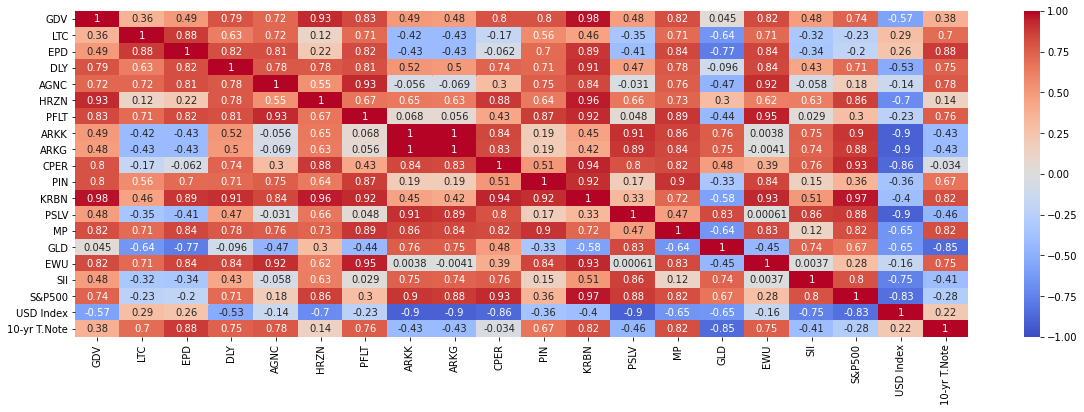

In [273]:
#correlatoin heatmap - individual stock against S&P 500/ US Dollar Index/ 10 Year US Treasury Notes
plt.figure(figsize=(20,6))
#mask = np.triu(np.ones_like(df.corr(), dtype=np.bool)) --> add syntax mask=mask to produce diagonal heatmap
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center=0, cmap='coolwarm')

**Portfolio Optimization (Yield not Considered)**

In [274]:
#List of stocks to be considered in a portfolio

#max return list
buylist = ['GDV', 'LTC', 'EPD', 'AGNC', 'PFLT', 'ARKK', 'CPER', 'PIN', 'KRBN', 'EWU']
weight = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

#max yield list
#buylist = ['GDV', 'LTC', 'EPD', 'AGNC', 'PFLT']
#weight = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

historical_datas_buylist = {}
bl=pd.DataFrame()

# build tickker list to dictionary
for ticker in buylist:
    historical_datas_buylist[ticker] = get_data(ticker, start_date=start_date, index_as_date = True, interval="1d")

# put closing price into dataframe
for key in historical_datas_buylist.keys():
  bl = pd.concat([bl, historical_datas_buylist[key]['close']], axis=1)
  bl.rename(columns={'close':key}, inplace=True)

bl_returns = bl.pct_change().round(4)

In [275]:
#calculating portfolio variance basd on stock buy list
cov_matrix_annual = bl_returns.cov()*253 #--> aveage nasdaq trading days
portfolio_variance = np.dot(weight.T, np.dot(cov_matrix_annual, weight))
print('Portfolio variance:', portfolio_variance.round(3))

Portfolio variance: 0.058


In [276]:
#calculating portfolio volatility
portfolio_volatility = np.sqrt(portfolio_variance)
portfolio_volatility.round(4)

0.2409

Machine recommended portfolio weighting, based on the stock list provided. Portfolio optimized assuming maximum Sharp Ratio (i.e. maximizing risk adjusted returns against risk free assets)

In [277]:
mu = expected_returns.ema_historical_return(bl) 
s = risk_models.sample_cov(bl)
ef = EfficientFrontier(mu, s)
weight_ef = ef.max_sharpe()
clean_weights = ef.clean_weights()
clean_weights

OrderedDict([('GDV', 0.0),
             ('LTC', 0.0),
             ('EPD', 0.0),
             ('AGNC', 0.0),
             ('PFLT', 0.02751),
             ('ARKK', 0.11856),
             ('CPER', 0.16673),
             ('PIN', 0.0),
             ('KRBN', 0.6872),
             ('EWU', 0.0)])

In [278]:
ef.portfolio_performance(verbose=True)

Expected annual return: 73.2%
Annual volatility: 24.7%
Sharpe Ratio: 2.88


(0.7317120591033706, 0.24679692831704345, 2.8837962609853953)

General guidance in reading the Sharpe Ratio:
*   Greater than 1.0 - usually considered acceptable to good by investors
*   Greater than 2.0 - very good 
*   Greater than 3.0 - excellent

**Checking the Fundamentals of the Portfolio** **bold text**

In [279]:
fundamentals = []

for ticker in buylist:
  fundamentals.append(get_quote_table(ticker))

df_zip = dict(zip(buylist, fundamentals))
df = pd.concat({k: pd.DataFrame.from_dict(v, 'index').T for k, v in df_zip.items()}, axis=0).reset_index()

In [280]:
df = df.drop(['level_1', 'Ask', 'Avg. Volume', 'Bid', 'Day\'s Range', 'Open', 
              'Previous Close', 'Quote Price', 'Volume', 'Expense Ratio (net)', 'Inception Date'  ], axis=1)
df.rename(columns={'level_0': 'Tickers'})

,Tickers,1y Target Est,52 Week Range,Beta (5Y Monthly),EPS (TTM),Earnings Date,Ex-Dividend Date,Forward Dividend & Yield,Market Cap,PE Ratio (TTM),NAV,Net Assets,YTD Daily Total Return,Yield
0,GDV,NaN,17.46 - 26.95,1.35,2.05,NaN,"Aug 16, 2021",1.32 (4.92%),2.425B,13.07,NaN,NaN,NaN,NaN
1,LTC,38.88,32.01 - 44.73,0.96,1.57,"Oct 27, 2021 - Nov 01, 2021","Aug 20, 2021",2.28 (6.42%),1.398B,22.65,NaN,NaN,NaN,NaN
2,EPD,28.35,14.90 - 25.69,1.37,1.74,"Oct 26, 2021 - Nov 01, 2021","Jul 29, 2021",1.80 (7.99%),49.215B,12.91,NaN,NaN,NaN,NaN
3,AGNC,18.08,13.53 - 18.84,1.02,3.52,"Oct 25, 2021 - Oct 29, 2021","Jul 29, 2021",1.44 (8.81%),8.577B,4.64,NaN,NaN,NaN,NaN
4,PFLT,13.08,7.70 - 13.50,2.02,1.79,"Aug 04, 2021","Aug 17, 2021",1.14 (8.57%),515.669M,7.42,NaN,NaN,NaN,NaN
5,ARKK,NaN,81.33 - 159.70,1.56,NaN,NaN,NaN,NaN,NaN,NaN,120.07,25.52B,-3.51%,0.00%
6,CPER,NaN,17.70 - 29.60,1.13,NaN,NaN,NaN,NaN,NaN,3.1,26.9,300.79M,23.86%,0.00%
7,PIN,NaN,18.50 - 27.25,0.93,NaN,NaN,NaN,NaN,NaN,NaN,26.98,112.89M,16.86%,0.44%
8,KRBN,NaN,18.88 - 37.98,0,NaN,NaN,NaN,NaN,NaN,NaN,36.61,535.8M,50.29%,0.00%
9,EWU,NaN,24.02 - 34.26,1.08,NaN,NaN,NaN,NaN,NaN,15.35,33.71,3.46B,16.28%,2.74%
